# Baseline Models 


In [1]:
# ========================================
# BASELINE MODELS 
# ========================================

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Настройка визуализации
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n" + "="*70)
print(" BASELINE MODELS")
print("="*70)


 BASELINE MODELS


## 1. Загрузка данных

In [2]:
print("\n[1/8] Загрузка данных...")

train_df = pd.read_csv('train_features_full.csv')
test_df = pd.read_csv('test_features_full.csv')

# Для простых baseline моделей
train_simple = train_df[['user_id', 'book_id', 'rating']].copy()
test_simple = test_df[['user_id', 'book_id', 'rating']].copy()

print(f"  Train: {len(train_simple):,} оценок")
print(f"  Test: {len(test_simple):,} оценок")
print(f"  Train features: {train_df.shape[1]} колонок")
print(f"  Test features: {test_df.shape[1]} колонок")

# Статистика рейтингов
print(f"\n  Распределение рейтингов (train):")
rating_dist = train_simple['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    pct = count / len(train_simple) * 100
    print(f"   {rating:.0f} : {count:>7,} ({pct:>5.1f}%)")

global_mean = train_simple['rating'].mean()
print(f"\n • Global mean rating: {global_mean:.4f}")
print(f" • Median rating: {train_simple['rating'].median():.1f}")


[1/8] Загрузка данных...
  Train: 874,496 оценок
  Test: 107,260 оценок
  Train features: 21 колонок
  Test features: 21 колонок

  Распределение рейтингов (train):
   1 :  17,504 (  2.0%)
   2 :  56,212 (  6.4%)
   3 : 221,314 ( 25.3%)
   4 : 317,958 ( 36.4%)
   5 : 261,508 ( 29.9%)

 • Global mean rating: 3.8574
 • Median rating: 4.0


## 2. Функции для метрик

In [3]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Вычисляет метрики качества:
    - RMSE (общий)
    - MAE (общий)
    - RMSE по rating buckets (low: <=3, high: >=4)
    """
    # Ограничиваем предсказания диапазоном [1, 5]
    y_pred_clipped = np.clip(y_pred, 1, 5)
    
    # Общие метрики
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_clipped))
    mae = mean_absolute_error(y_true, y_pred_clipped)
    
    # Метрики по bucket'ам
    low_mask = y_true <= 3
    high_mask = y_true >= 4
    
    if low_mask.sum() > 0:
        rmse_low = np.sqrt(mean_squared_error(y_true[low_mask], y_pred_clipped[low_mask]))
        mae_low = mean_absolute_error(y_true[low_mask], y_pred_clipped[low_mask])
    else:
        rmse_low = mae_low = np.nan
    
    if high_mask.sum() > 0:
        rmse_high = np.sqrt(mean_squared_error(y_true[high_mask], y_pred_clipped[high_mask]))
        mae_high = mean_absolute_error(y_true[high_mask], y_pred_clipped[high_mask])
    else:
        rmse_high = mae_high = np.nan
    
    results = {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'rmse_low': rmse_low,
        'rmse_high': rmse_high,
        'mae_low': mae_low,
        'mae_high': mae_high,
        'n_low': low_mask.sum(),
        'n_high': high_mask.sum()
    }
    
    return results

def print_metrics(results):
    """печатает метрики"""
    print(f"\n  {results['model']}:")
    print(f"   • RMSE (overall): {results['rmse']:.4f}")
    print(f"   • MAE (overall): {results['mae']:.4f}")
    print(f"   • RMSE (low ≤3): {results['rmse_low']:.4f} (n={results['n_low']:,})")
    print(f"   • RMSE (high ≥4): {results['rmse_high']:.4f} (n={results['n_high']:,})")

## 3. Baseline 1: Random Predictions

In [4]:
print("\n" + "="*70)
print("[2/8] BASELINE 1: RANDOM PREDICTIONS")
print("="*70)

print("\n Генерация случайных предсказаний [1, 5]...")

np.random.seed(42)
y_test = test_simple['rating'].values

# Случайные целочисленные оценки от 1 до 5
random_pred = np.random.randint(1, 6, size=len(y_test))

random_results = calculate_metrics(y_test, random_pred, "Random Baseline")
print_metrics(random_results)


[2/8] BASELINE 1: RANDOM PREDICTIONS

 Генерация случайных предсказаний [1, 5]...

  Random Baseline:
   • RMSE (overall): 1.9234
   • MAE (overall): 1.5400
   • RMSE (low ≤3): 1.5588 (n=36,399)
   • RMSE (high ≥4): 2.0861 (n=70,861)


## 4. Baseline 2: Global Average

In [5]:
print("\n" + "="*70)
print("[3/8] BASELINE 2: GLOBAL AVERAGE")
print("="*70)

print(f"\n Предсказание = {global_mean:.4f} для всех пользователей и книг...")

global_pred = np.full(len(y_test), global_mean)

global_results = calculate_metrics(y_test, global_pred, "Global Average")
print_metrics(global_results)


[3/8] BASELINE 2: GLOBAL AVERAGE

 Предсказание = 3.8574 для всех пользователей и книг...

  Global Average:
   • RMSE (overall): 0.9802
   • MAE (overall): 0.7825
   • RMSE (low ≤3): 1.2966 (n=36,399)
   • RMSE (high ≥4): 0.7687 (n=70,861)


## 5. Baseline 3: User Average 


In [6]:
print("\n" + "="*70)
print("[4/8] BASELINE 3: USER AVERAGE")
print("="*70)

print("\n Используем avg_user_rating из feature engineering...")

#  используем готовый признак вместо пересчета
if 'avg_user_rating' in test_df.columns:
    user_pred = test_df['avg_user_rating'].fillna(global_mean).values
    print(f" Использован готовый признак avg_user_rating")
else:
    # пересчитываем, если признака нет
    user_avg = train_simple.groupby('user_id')['rating'].mean().to_dict()
    user_pred = test_simple['user_id'].map(user_avg).fillna(global_mean).values
    print(f"  Признак не найден, пересчитан из train")

user_results = calculate_metrics(y_test, user_pred, "User Average")
print_metrics(user_results)


[4/8] BASELINE 3: USER AVERAGE

 Используем avg_user_rating из feature engineering...
 Использован готовый признак avg_user_rating

  User Average:
   • RMSE (overall): 0.9104
   • MAE (overall): 0.6971
   • RMSE (low ≤3): 1.1589 (n=36,399)
   • RMSE (high ≥4): 0.7515 (n=70,861)


## 6. Baseline 4: Book Average 



In [7]:
print("\n" + "="*70)
print("[5/8] BASELINE 4: BOOK AVERAGE")
print("="*70)

print("\n Используем book_avg_rating из feature engineering...")

# используем готовый признак
if 'book_avg_rating' in test_df.columns:
    book_pred = test_df['book_avg_rating'].fillna(global_mean).values
    print(f"  Использован готовый признак book_avg_rating")
else:
    book_avg = train_simple.groupby('book_id')['rating'].mean().to_dict()
    book_pred = test_simple['book_id'].map(book_avg).fillna(global_mean).values
    print(f"   Признак не найден, пересчитан из train")

book_results = calculate_metrics(y_test, book_pred, "Book Average")
print_metrics(book_results)


[5/8] BASELINE 4: BOOK AVERAGE

 Используем book_avg_rating из feature engineering...
  Использован готовый признак book_avg_rating

  Book Average:
   • RMSE (overall): 0.9571
   • MAE (overall): 0.7677
   • RMSE (low ≤3): 1.2395 (n=36,399)
   • RMSE (high ≥4): 0.7730 (n=70,861)


## 7. Baseline 5: Goodreads Average 

Используем средний рейтинг книги на Goodreads из preprocessing

In [8]:
print("\n" + "="*70)
print("[6/8] BASELINE 5: GOODREADS AVERAGE")
print("="*70)

print("\n Используем average_rating из Goodreads (preprocessing)...")

#  используем готовый Goodreads rating
if 'average_rating' in test_df.columns:
    goodreads_pred = test_df['average_rating'].fillna(global_mean).values
    goodreads_results = calculate_metrics(y_test, goodreads_pred, "Goodreads Average")
    print_metrics(goodreads_results)
    print(f"  Использован Goodreads rating из preprocessing")
else:
    print(f"   Признак average_rating не найден, пропускаем")
    goodreads_results = None


[6/8] BASELINE 5: GOODREADS AVERAGE

 Используем average_rating из Goodreads (preprocessing)...

  Goodreads Average:
   • RMSE (overall): 0.9450
   • MAE (overall): 0.7474
   • RMSE (low ≤3): 1.3258 (n=36,399)
   • RMSE (high ≥4): 0.6700 (n=70,861)
  Использован Goodreads rating из preprocessing


## 8. Baseline 6: User + Book Bias 


In [9]:
print("\n" + "="*70)
print("[7/8] BASELINE 6: USER + BOOK BIAS ")
print("="*70)

print("\n Вычисление bias'ов с регуляризацией...")

def calculate_biases(train_df, reg_user=10, reg_book=25):
    """
    Вычисляет user и book biases с регуляризацией:
    
    prediction = global_mean + user_bias + book_bias
    
    user_bias = (sum_user_ratings - user_count * global_mean) / (user_count + reg_user)
    book_bias = (sum_book_ratings - book_count * global_mean) / (book_count + reg_book)
    
    Регуляризация предотвращает переобучение для редких пользователей/книг.
    """
    global_mean = train_df['rating'].mean()
    
    # User bias
    user_stats = train_df.groupby('user_id')['rating'].agg(['sum', 'count'])
    user_bias = (user_stats['sum'] - user_stats['count'] * global_mean) / (user_stats['count'] + reg_user)
    user_bias_dict = user_bias.to_dict()
    
    # Book bias
    book_stats = train_df.groupby('book_id')['rating'].agg(['sum', 'count'])
    book_bias = (book_stats['sum'] - book_stats['count'] * global_mean) / (book_stats['count'] + reg_book)
    book_bias_dict = book_bias.to_dict()
    
    return global_mean, user_bias_dict, book_bias_dict

# Вычисляем biases
global_mean_bias, user_bias_dict, book_bias_dict = calculate_biases(
    train_simple, 
    reg_user=10,
    reg_book=25
)

print(f" User biases: {len(user_bias_dict):,}")
print(f" Book biases: {len(book_bias_dict):,}")

#  векторизованная версия применения bias'ов
print("\n Применение bias'ов к тесту (векторизованная версия)...")

test_simple_bias = test_simple.copy()
test_simple_bias['user_bias'] = test_simple_bias['user_id'].map(user_bias_dict).fillna(0)
test_simple_bias['book_bias'] = test_simple_bias['book_id'].map(book_bias_dict).fillna(0)
bias_pred = (global_mean_bias + 
             test_simple_bias['user_bias'] + 
             test_simple_bias['book_bias']).values

bias_results = calculate_metrics(y_test, bias_pred, "User + Book Bias")
print_metrics(bias_results)

# Дополнительная статистика по bias'ам
print(f"\n Статистика bias'ов:")
user_biases = np.array(list(user_bias_dict.values()))
book_biases = np.array(list(book_bias_dict.values()))

print(f"   User bias: mean={user_biases.mean():.3f}, std={user_biases.std():.3f}")
print(f"   Book bias: mean={book_biases.mean():.3f}, std={book_biases.std():.3f}")


[7/8] BASELINE 6: USER + BOOK BIAS 

 Вычисление bias'ов с регуляризацией...
 User biases: 53,424
 Book biases: 9,996

 Применение bias'ов к тесту (векторизованная версия)...

  User + Book Bias:
   • RMSE (overall): 0.8678
   • MAE (overall): 0.6883
   • RMSE (low ≤3): 1.1373 (n=36,399)
   • RMSE (high ≥4): 0.6896 (n=70,861)

 Статистика bias'ов:
   User bias: mean=0.005, std=0.272
   Book bias: mean=0.001, std=0.233


## 9. Baseline 7: Ridge Regression  



In [15]:
print("\n" + "="*70)
print("[8/8] BASELINE 7: RIDGE REGRESSION ")
print("="*70)

print("\n Подготовка признаков из feature engineering...")

# используем  признаки из feature engineering
feature_cols = [
    # Interaction Features (6)
    'tag_overlap_count', 'tag_overlap_ratio', 'tag_jaccard',
    'history_similarity', 'embedding_cosine_sim', 'embedding_euclidean_dist',
    # User Features (4)
    'avg_user_rating', 'ratings_count', 'tag_vocab_size', 'activity_score',
    # Book Features (3)
    'book_avg_rating', 'book_ratings_count', 'book_popularity',
    # Preprocessing Features (4)
    'language_code_encoded', 'year_normalized', 'publication_era', 'average_rating'
]

#  проверка наличия колонок
missing_cols = set(feature_cols) - set(train_df.columns)
if missing_cols:
    print(f"   WARNING: Missing columns: {missing_cols}")
    feature_cols = [col for col in feature_cols if col in train_df.columns]
    print(f"  Using {len(feature_cols)} available features")
else:
    print(f"  All {len(feature_cols)} features found")

# Проверка на NaN
print("\n Проверка на пропущенные значения...")
train_nan = train_df[feature_cols].isnull().sum().sum()
test_nan = test_df[feature_cols].isnull().sum().sum()

if train_nan > 0 or test_nan > 0:
    print(f"   Train NaN: {train_nan}, Test NaN: {test_nan}")
    print("  Заполняем нули...")
    train_df[feature_cols] = train_df[feature_cols].fillna(0)
    test_df[feature_cols] = test_df[feature_cols].fillna(0)
else:
    print("  Пропусков нет")

# Подготовка данных
X_train = train_df[feature_cols].values
y_train = train_df['rating'].values
X_test = test_df[feature_cols].values

print(f"\n X_train shape: {X_train.shape}")
print(f" X_test shape: {X_test.shape}")

# Масштабирование
print("\n Масштабирование признаков (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение Ridge
print("\n Обучение Ridge Regression (alpha=1.0)...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)

# Предсказание
ridge_pred = ridge.predict(X_test_scaled)

ridge_results = calculate_metrics(y_test, ridge_pred, "Ridge (all features)")
print_metrics(ridge_results)

# Топ важных признаков (по абсолютным коэффициентам)
print("\n Топ-10 важных признаков (по коэффициентам):")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': ridge.coef_
})
feature_importance['abs_coef'] = feature_importance['coefficient'].abs()
top_features = feature_importance.nlargest(10, 'abs_coef')

for idx, row in top_features.iterrows():
    print(f"   {row['feature']:<30s}: {row['coefficient']:>8.4f}")


[8/8] BASELINE 7: RIDGE REGRESSION 

 Подготовка признаков из feature engineering...
  All 17 features found

 Проверка на пропущенные значения...
  Пропусков нет

 X_train shape: (874496, 17)
 X_test shape: (107260, 17)

 Масштабирование признаков (StandardScaler)...

 Обучение Ridge Regression (alpha=1.0)...

  Ridge (all features):
   • RMSE (overall): 0.8104
   • MAE (overall): 0.6216
   • RMSE (low ≤3): 1.0433 (n=36,399)
   • RMSE (high ≥4): 0.6596 (n=70,861)

 Топ-10 важных признаков (по коэффициентам):
   avg_user_rating               :   0.4998
   embedding_euclidean_dist      :  -0.2491
   book_avg_rating               :   0.2391
   tag_vocab_size                :   0.1122
   embedding_cosine_sim          :  -0.0840
   ratings_count                 :  -0.0498
   book_popularity               :   0.0446
   average_rating                :  -0.0419
   book_ratings_count            :  -0.0232
   tag_overlap_count             :   0.0189


## 10. Сравнение всех моделей

In [11]:
print("\n" + "="*70)
print(" СРАВНЕНИЕ ВСЕХ BASELINE МОДЕЛЕЙ")
print("="*70)

# Собираем все результаты
all_results_list = [
    random_results,
    global_results,
    user_results,
    book_results,
    bias_results,
    ridge_results
]

# Добавляем Goodreads, если есть
if goodreads_results is not None:
    all_results_list.insert(-1, goodreads_results)

all_results = pd.DataFrame(all_results_list)

print("\n Таблица результатов:")
print(" " + "="*68)
print(f" {'Model':<25} {'RMSE':<10} {'MAE':<10} {'RMSE(low)':<12} {'RMSE(high)':<12}")
print(" " + "="*68)

for _, row in all_results.iterrows():
    print(f" {row['model']:<25} {row['rmse']:<10.4f} {row['mae']:<10.4f} "
          f"{row['rmse_low']:<12.4f} {row['rmse_high']:<12.4f}")

print(" " + "="*68)

# Лучшая модель
best_model = all_results.loc[all_results['rmse'].idxmin(), 'model']
best_rmse = all_results['rmse'].min()

print(f"\n  Лучшая baseline модель: {best_model}")
print(f"   RMSE: {best_rmse:.4f}")

# Улучшение относительно Global Average
improvement = (global_results['rmse'] - best_rmse) / global_results['rmse'] * 100
print(f"   Улучшение vs Global Average: {improvement:.2f}%")

# Улучшение Ridge vs Bias
if 'Ridge' in best_model:
    ridge_improvement = (bias_results['rmse'] - best_rmse) / bias_results['rmse'] * 100
    print(f"   Улучшение vs User+Book Bias: {ridge_improvement:.2f}%")


 СРАВНЕНИЕ ВСЕХ BASELINE МОДЕЛЕЙ

 Таблица результатов:
 Model                     RMSE       MAE        RMSE(low)    RMSE(high)  
 Random Baseline           1.9234     1.5400     1.5588       2.0861      
 Global Average            0.9802     0.7825     1.2966       0.7687      
 User Average              0.9104     0.6971     1.1589       0.7515      
 Book Average              0.9571     0.7677     1.2395       0.7730      
 User + Book Bias          0.8678     0.6883     1.1373       0.6896      
 Goodreads Average         0.9450     0.7474     1.3258       0.6700      
 Ridge (all features)      0.8104     0.6216     1.0433       0.6596      

  Лучшая baseline модель: Ridge (all features)
   RMSE: 0.8104
   Улучшение vs Global Average: 17.32%
   Улучшение vs User+Book Bias: 6.61%


## 11. Визуализация 


 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

 График сохранен: baseline_comparison.png


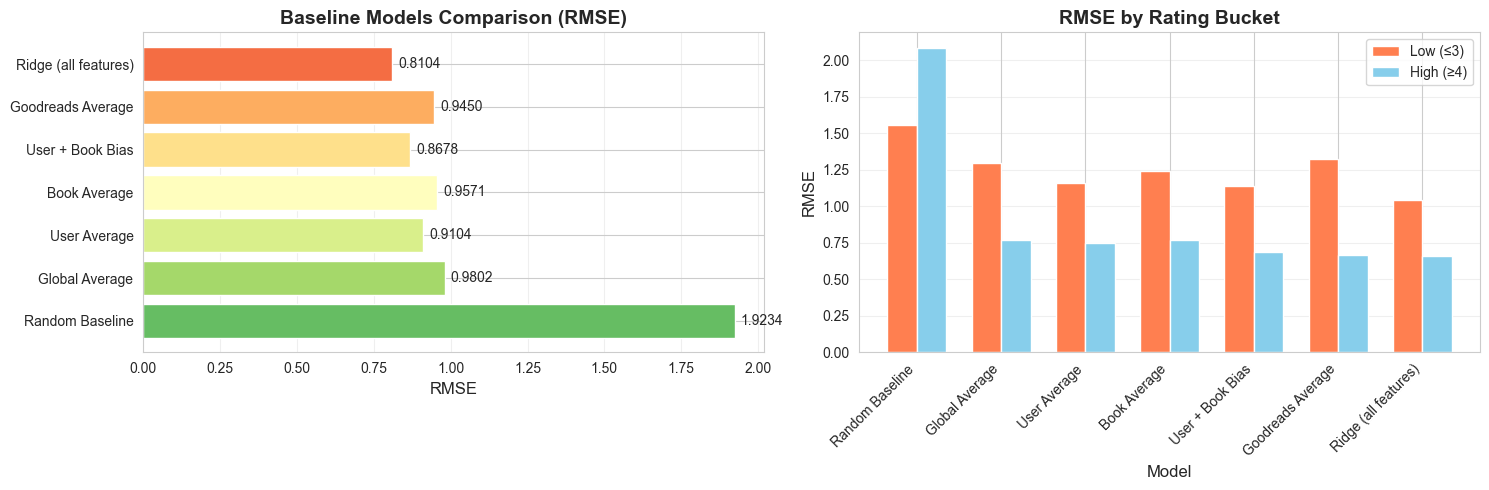

 График сохранен: baseline_error_distributions.png


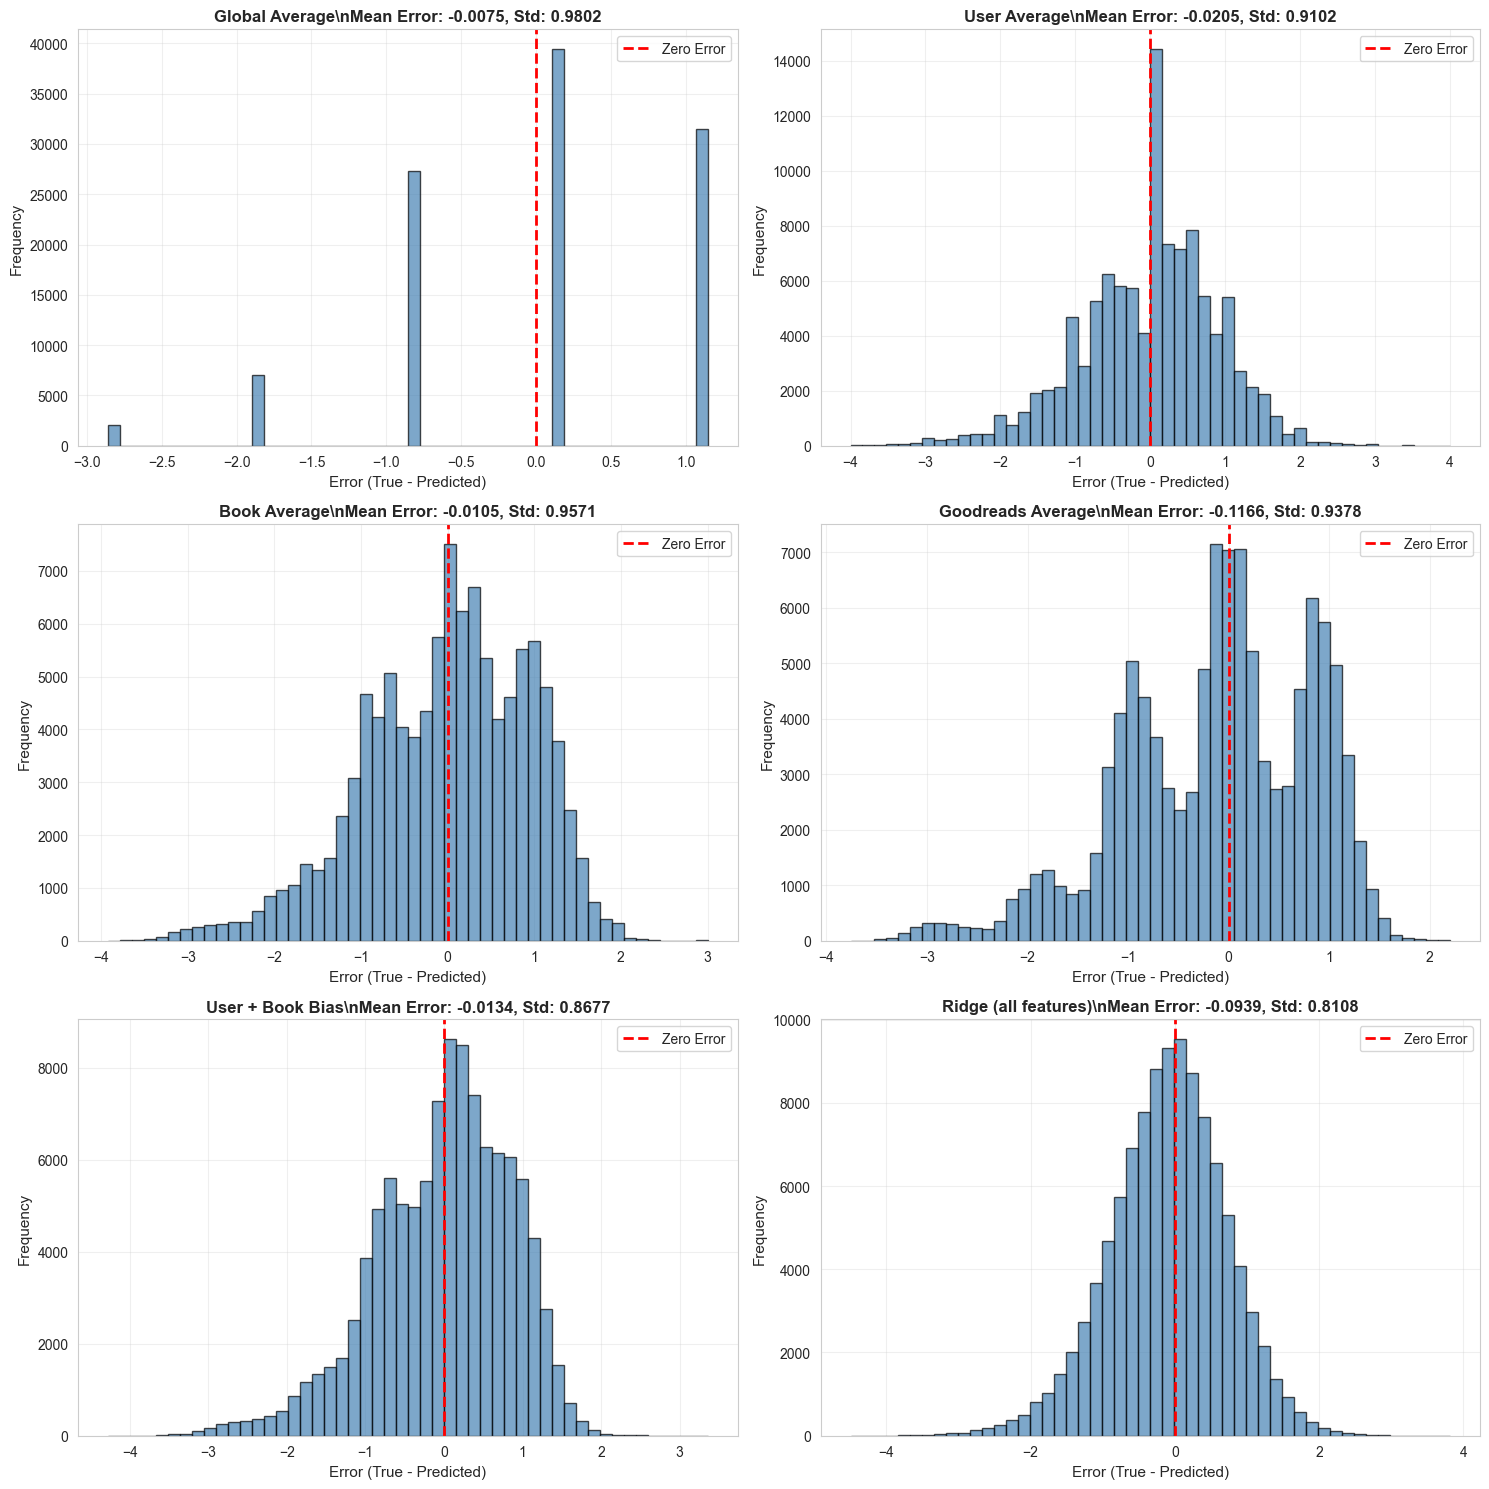

In [12]:
print("\n" + "="*70)
print(" ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*70)

def plot_model_comparison(all_results):
    """График сравнения RMSE моделей"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Overall RMSE
    ax1 = axes[0]
    models = all_results['model'].values
    rmse_values = all_results['rmse'].values
    
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(models)))
    bars = ax1.barh(models, rmse_values, color=colors)
    
    ax1.set_xlabel('RMSE', fontsize=12)
    ax1.set_title('Baseline Models Comparison (RMSE)', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Добавляем значения
    for i, (bar, value) in enumerate(zip(bars, rmse_values)):
        ax1.text(value + 0.02, i, f'{value:.4f}', va='center', fontsize=10)
    
    # RMSE по bucket'ам
    ax2 = axes[1]
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, all_results['rmse_low'], width, 
                    label='Low (≤3)', color='coral')
    bars2 = ax2.bar(x + width/2, all_results['rmse_high'], width, 
                    label='High (≥4)', color='skyblue')
    
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('RMSE', fontsize=12)
    ax2.set_title('RMSE by Rating Bucket', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('baseline_comparison.png', dpi=300, bbox_inches='tight')
    print("\n График сохранен: baseline_comparison.png")
    plt.show()

def plot_error_distributions(models_predictions, y_test):
    """График распределения ошибок для выбранных моделей"""
    n_models = len(models_predictions)
    rows = (n_models + 1) // 2
    
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5*rows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, (model_name, predictions) in enumerate(models_predictions):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        errors = y_test - predictions
        
        ax.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
        ax.set_xlabel('Error (True - Predicted)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'{model_name}\\nMean Error: {errors.mean():.4f}, Std: {errors.std():.4f}', 
                     fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
    
    # Удаляем лишние subplots
    for idx in range(len(models_predictions), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.savefig('baseline_error_distributions.png', dpi=300, bbox_inches='tight')
    print(" График сохранен: baseline_error_distributions.png")
    plt.show()

# Вызов функций визуализации
plot_model_comparison(all_results)

models_to_plot = [
    ('Global Average', global_pred),
    ('User Average', user_pred),
    ('Book Average', book_pred),
    ('User + Book Bias', bias_pred),
    ('Ridge (all features)', ridge_pred)
]

if goodreads_results is not None:
    models_to_plot.insert(3, ('Goodreads Average', goodreads_pred))

plot_error_distributions(models_to_plot, y_test)

## 12. Сохранение результатов

In [13]:
print("\n" + "="*70)
print(" СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*70)

# Сохраняем таблицу результатов
all_results.to_csv('baseline_results.csv', index=False)
print("\n  baseline_results.csv")

# Сохраняем артефакты для следующих ноутбуков
baseline_artifacts = {
    'global_mean': global_mean_bias,
    'user_bias_dict': user_bias_dict,
    'book_bias_dict': book_bias_dict,
    'best_baseline_model': best_model,
    'best_baseline_rmse': best_rmse,
    'ridge_model': ridge,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'ridge_coef': dict(zip(feature_cols, ridge.coef_))
}

with open('baseline_artifacts.pkl', 'wb') as f:
    pickle.dump(baseline_artifacts, f)

print("  baseline_artifacts.pkl")

# Сохраняем предсказания лучшей модели
if 'Ridge' in best_model:
    best_predictions = ridge_pred
else:
    best_predictions = bias_pred

np.save('baseline_predictions_test.npy', best_predictions)
print("  baseline_predictions_test.npy")


 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ

  baseline_results.csv
  baseline_artifacts.pkl
  baseline_predictions_test.npy


## 13. Финальная статистика

In [14]:
print("\n" + "="*70)
print("BASELINE MODELS - ЗАВЕРШЕНО")
print("="*70)

print(f"\nИтоговая статистика:")
print(f"\n Протестировано моделей: {len(all_results)}")
print(f" Лучшая модель: {best_model}")
print(f" Лучший RMSE: {best_rmse:.4f}")
print(f" Худший RMSE: {random_results['rmse']:.4f} (Random)")
print(f" Улучшение: {(random_results['rmse'] - best_rmse):.4f} (-{(random_results['rmse'] - best_rmse)/random_results['rmse']*100:.1f}%)")

print(f"\n  Созданные файлы:")
print(f"   • baseline_results.csv")
print(f"   • baseline_artifacts.pkl (включает Ridge model + scaler)")
print(f"   • baseline_predictions_test.npy")
print(f"   • baseline_comparison.png")
print(f"   • baseline_error_distributions.png")




BASELINE MODELS - ЗАВЕРШЕНО

Итоговая статистика:

 Протестировано моделей: 7
 Лучшая модель: Ridge (all features)
 Лучший RMSE: 0.8104
 Худший RMSE: 1.9234 (Random)
 Улучшение: 1.1130 (-57.9%)

  Созданные файлы:
   • baseline_results.csv
   • baseline_artifacts.pkl (включает Ridge model + scaler)
   • baseline_predictions_test.npy
   • baseline_comparison.png
   • baseline_error_distributions.png
